# Intel Image Classification Project
- **Nama:** Muhammad Aldy Naufal Fadhilah
- **Email:** aldy.naufal02@gmail.com
- **ID Dicoding:** aldy_naufal

In [3]:
%pip install -r requirements.txt

  Obtaining dependency information for split-folders from https://files.pythonhosted.org/packages/b6/d5/307d63c03356bad6e141d8718d3f4116f51bd9c4b09e2614ffcee1f3c6fd/split_folders-0.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


Sebelum memulai pemrosesan data, terlebih dahulu kita perlu memastikan bahwa semua library atau paket yang dibutuhkan oleh program telah terpasang di lingkungan pengembangan kita. Untuk itu, kita menggunakan perintah `%pip install -r requirements.txt`. Perintah ini akan membaca isi file *requirements.txt* yang berisi daftar semua paket Python beserta versi yang diperlukan untuk menjalankan program dengan baik. Dengan menjalankan perintah ini, pip akan secara otomatis mengunduh dan menginstal seluruh dependensi tersebut, sehingga lingkungan kerja kita sudah siap dan tidak akan mengalami error akibat paket yang belum terpasang saat menjalankan kode selanjutnya.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import splitfolders
from tensorflow.keras.applications import MobileNetV2

Setelah memastikan semua dependensi telah terpasang dengan baik, saya melakukan proses *import* berbagai library yang akan digunakan dalam pengembangan model machine learning. Saya mengimpor modul *TensorFlow* beserta submodulnya seperti *keras*, *layers*, *models*, dan *callbacks* untuk membangun serta melatih model neural network. Selain itu, saya juga mengimpor beberapa *callback* penting seperti *EarlyStopping*, *ModelCheckpoint*, dan *ReduceLROnPlateau* yang digunakan untuk mengoptimalkan proses pelatihan model. Untuk keperluan visualisasi dan analisis data, saya menggunakan *matplotlib.pyplot*, serta *numpy* untuk melakukan berbagai operasi numerik. Saya juga mengimpor modul *os* yang berguna dalam pengelolaan file dan direktori, serta *PIL.Image* untuk memproses dan memanipulasi data citra yang akan digunakan dalam pelatihan model. Dengan semua library ini, saya telah menyiapkan lingkungan yang lengkap untuk membangun, melatih, dan mengevaluasi model deep learning berbasis data gambar.


In [5]:
# Path ke dataset awal
input_folder = 'data/data'  # Folder yang berisi class folders

# Path output akan otomatis jadi: data/train, data/val, data/test
output_folder = 'data'

# Membagi dataset: 70% train, 15% val, 15% test (bisa ubah kalau mau)
splitfolders.ratio(input_folder, output=output_folder, seed=123, ratio=(0.7, 0.15, 0.15), group_prefix=None)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class: buildings | Image: 0.jpg | Original size: (150, 150)
Class: forest | Image: 10007.jpg | Original size: (150, 150)
Class: glacier | Image: 10.jpg | Original size: (150, 150)
Class: mountain | Image: 10000.jpg | Original size: (150, 150)
Class: sea | Image: 1.jpg | Original size: (150, 150)
Class: street | Image: 1000.jpg | Original size: (150, 150)


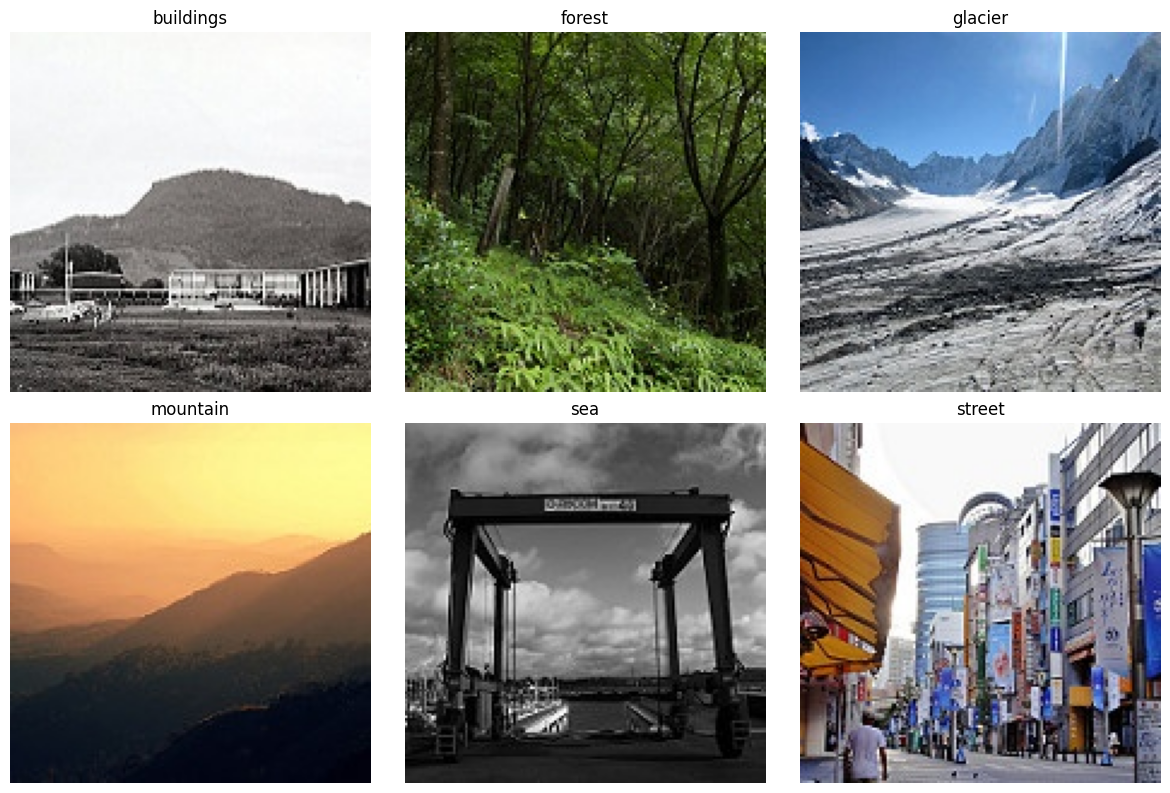

In [6]:
# Path ke folder data train
path = "data/train"

# Ambil semua nama folder class
class_names = os.listdir(path)
print(f"Classes: {class_names}")

# Buat canvas untuk plot
plt.figure(figsize=(12, 8))

# Untuk setiap class, ambil 1 gambar saja
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(path, class_name)

    # List semua gambar dalam folder class
    images = os.listdir(class_path)
    if not images:
        continue  # skip kalau folder kosong

    img_path = os.path.join(class_path, images[0])  # ambil 1 gambar pertama
    img = Image.open(img_path)

    print(f"Class: {class_name} | Image: {images[0]} | Original size: {img.size}")

    # Resize hanya untuk tampilan (contoh: maksimum sisi 256px)
    max_size = 256
    img.thumbnail((max_size, max_size))

    # Plot gambar
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

Pertama-tama saya melakukan eksplorasi awal terhadap data gambar yang saya miliki untuk memahami struktur dan bentuk datanya. Saya menentukan *path* menuju folder dataset pelatihan, lalu menggunakan modul *os* untuk mengambil daftar semua nama folder yang merepresentasikan masing-masing kelas dalam dataset. Setiap folder ini berisi gambar-gambar yang termasuk dalam kelas tersebut. Untuk mendapatkan gambaran visual tentang data, saya mengambil satu gambar dari setiap kelas dan menampilkannya menggunakan *matplotlib*. Saya juga mencetak informasi nama kelas, nama file gambar, dan ukuran asli gambar tersebut untuk memastikan integritas dan keberagaman data. Sebelum ditampilkan, gambar saya *resize* menggunakan metode *thumbnail* agar sesuai dalam tampilan plot. Dengan cara ini, saya bisa memverifikasi secara visual apakah data sudah sesuai dan apakah gambar dalam setiap kelas sudah terstruktur dengan baik sebelum melanjutkan ke tahap preprocessing dan pelatihan model.

In [7]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Kelas:", class_names)


Found 14021 files belonging to 6 classes.
Found 3002 files belonging to 6 classes.
Found 3011 files belonging to 6 classes.
Kelas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']



Selanjutnya saya mempersiapkan data agar siap digunakan dalam proses pelatihan model dengan cara memuat dataset gambar ke dalam format *TensorFlow Dataset*. Saya menggunakan fungsi `image_dataset_from_directory()` untuk secara otomatis memuat gambar dari folder direktori yang telah terstruktur berdasarkan kelas. Saya membuat tiga dataset terpisah, yaitu *train\_ds* untuk data pelatihan, *val\_ds* untuk data validasi, dan *test\_ds* untuk data pengujian. Dalam proses ini, saya menetapkan ukuran gambar yang seragam sebesar 256x256 piksel agar model dapat memproses input dengan konsisten, serta menggunakan *batch size* sebesar 32 agar data dibagi dalam kelompok kecil saat proses pelatihan. Saya juga mengatur *label\_mode* menjadi `'categorical'` karena saya menggunakan skenario *multi-class classification*, di mana label setiap gambar dikonversi menjadi vektor one-hot. Selain itu, saya menetapkan parameter `seed=123` untuk memastikan proses pengambilan data dilakukan secara acak namun tetap dapat direproduksi. Setelah dataset berhasil dimuat, saya mencetak daftar nama kelas untuk memastikan kembali bahwa semua kelas sudah terdeteksi dengan benar.


In [8]:
# 1. Definisikan data augmentation terpisah
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # Kurangi intensitas
    layers.RandomZoom(0.1),      # Kurangi intensitas
])

Untuk menghindari underfitting, saya melakukan teknik *data augmentation* yang bertujuan memperkaya variasi data latih tanpa perlu menambah jumlah data secara manual. Saya mendefinisikan *data augmentation* secara terpisah menggunakan *Sequential model* dari TensorFlow Keras. Dalam proses ini, saya menerapkan beberapa transformasi sederhana pada gambar seperti *RandomFlip* (membalik gambar secara horizontal), *RandomRotation* (memutar gambar secara acak dengan intensitas kecil sebesar 0.1), dan *RandomZoom* (melakukan pembesaran acak dengan intensitas sebesar 0.1). Transformasi ini dipilih dengan intensitas yang moderat agar gambar tetap merepresentasikan objek aslinya namun mampu memberikan model variasi sudut pandang dan skala. Dengan cara ini, model diharapkan tidak hanya menghafal gambar yang ada, tetapi juga mampu mengenali pola yang sama dalam kondisi gambar yang sedikit bervariasi, sehingga meningkatkan kemampuan generalisasi dan mengurangi risiko *underfitting* selama proses pelatihan.


In [11]:
# Transfer learning base
base_model = MobileNetV2(input_shape=(256, 256, 3),
                         include_top=False,  # tanpa classifier
                         weights='imagenet')

base_model.trainable = False  # Freeze weight pre-trained

# Model Sequential dengan tambahan Conv2D & Pooling
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # Pretrained Model (langsung setelah rescale)
    base_model,

    # Tambahkan Conv2D + Pooling (Syarat Wajib → setelah base model)
    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])



Selanjutnya masuk ke dalam tahap pemodelan, saya membangun arsitektur model *Convolutional Neural Network (CNN)* tanpa menerapkan *data augmentation* secara langsung di dalam model. Model saya definisikan menggunakan *Sequential API* dari TensorFlow Keras. Langkah pertama, saya melakukan *rescaling* pada gambar dengan membagi nilai piksel dengan 255 agar semua nilai berada dalam rentang \[0,1], sehingga mempercepat proses pelatihan dan meningkatkan stabilitas. Model terdiri dari tiga blok *Conv2D* dengan jumlah filter yang meningkat secara bertahap (32, 64, dan 128) untuk mengekstraksi fitur dari gambar, masing-masing diikuti oleh *BatchNormalization* untuk menstabilkan distribusi aktivasi, *ReLU activation* untuk menambahkan non-linearitas, dan *MaxPooling2D* untuk mereduksi dimensi fitur. Setelah ekstraksi fitur selesai, saya menggunakan lapisan *Flatten* untuk meratakan output dan melanjutkan dengan lapisan *Dense* berisi 128 neuron, diikuti *BatchNormalization*, *ReLU activation*, dan *Dropout* sebesar 0.5 untuk mencegah overfitting. Terakhir, lapisan *Dense* output menggunakan fungsi aktivasi *softmax* sesuai dengan jumlah kelas dalam dataset. Setelah model siap, saya menerapkan *data augmentation* yang sebelumnya sudah saya definisikan hanya pada dataset pelatihan dengan menggunakan fungsi `map()`. Dengan cara ini, setiap batch data yang masuk ke model saat pelatihan akan otomatis mendapatkan variasi tambahan, sehingga model mendapatkan data yang lebih beragam dan lebih tangguh dalam proses belajar.


Images shape: (32, 256, 256, 3)
Labels shape: (32, 6)
Sample labels: [0. 0. 0. 0. 1. 0.]


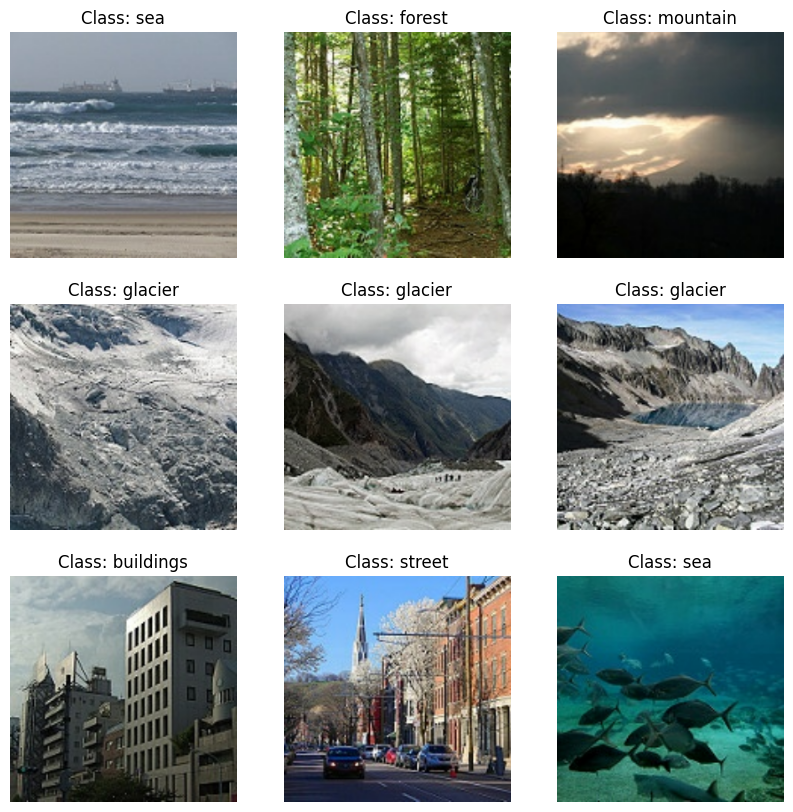

In [12]:
# Periksa format data
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample labels:", labels[0].numpy())

    # Visualisasikan beberapa gambar
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis("off")
    plt.show()


Sebelum melanjutkan ke proses pelatihan model, saya terlebih dahulu memeriksa format data yang telah dimuat dalam dataset untuk memastikan bahwa input dan label sudah sesuai dengan ekspektasi model. Saya mengambil satu batch dari *train\_ds* dan mencetak bentuk (shape) dari data gambar dan label. Dari hasil yang ditampilkan, saya memastikan bahwa gambar memiliki dimensi `(32, 256, 256, 3)` yang berarti ada 32 gambar dalam satu batch dengan resolusi 256x256 piksel dan 3 saluran warna (RGB). Label memiliki dimensi `(32, 6)` yang menunjukkan bahwa label telah berhasil dikonversi dalam format one-hot encoding untuk 6 kelas. Untuk memastikan kesesuaian antara gambar dan labelnya, saya juga memvisualisasikan 9 contoh gambar dari batch tersebut beserta label kelasnya. Hal ini saya lakukan dengan menampilkan gambar menggunakan *matplotlib* dan mencetak nama kelas berdasarkan posisi argmax dari label one-hot. Dengan langkah verifikasi ini, saya memastikan bahwa pipeline data sudah berjalan dengan baik, gambar terdistribusi dengan benar, dan label sudah sesuai sebelum data dimasukkan ke dalam proses pelatihan model.

In [13]:
# Kompilasi model dengan learning rate yang lebih kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Setelah memastikan data sudah dalam format yang benar, saya melanjutkan dengan proses kompilasi model agar siap untuk dilatih. Pada tahap ini, saya memilih menggunakan *Adam optimizer* yang terkenal efektif karena mampu menyesuaikan *learning rate* secara adaptif selama proses pelatihan. Namun, untuk menjaga stabilitas dan menghindari lonjakan gradien yang bisa menyebabkan model sulit konvergen, saya secara eksplisit menetapkan *learning rate* yang lebih kecil yaitu sebesar 0.0001. *Learning rate* yang kecil ini bertujuan agar proses pembaruan bobot berlangsung secara halus, terutama karena dataset gambar bisa memiliki kompleksitas yang tinggi. Saya menggunakan fungsi *loss* `categorical_crossentropy` karena permasalahan yang saya hadapi merupakan klasifikasi multi-kelas dengan label dalam bentuk one-hot encoding. Selain itu, saya menambahkan metrik *accuracy* untuk memantau kinerja model dalam mengklasifikasikan data selama pelatihan dan validasi. Dengan proses kompilasi ini, model telah siap untuk masuk ke tahap pelatihan menggunakan dataset yang sudah disiapkan.



In [14]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\n✅ Val accuracy {val_acc:.2f} reached threshold {self.threshold}, stopping training.")
            self.model.stop_training = True


Agar proses pelatihan lebih efisien dan tidak berlangsung lebih lama dari yang diperlukan, saya membuat sebuah *custom callback* bernama `AccuracyThresholdCallback`. Callback ini dirancang untuk menghentikan pelatihan secara otomatis apabila akurasi validasi (*validation accuracy*) sudah mencapai ambang batas tertentu yang saya tentukan, yaitu 95% (*threshold=0.95*). Dengan menggunakan subclass dari `tf.keras.callbacks.Callback`, saya mendefinisikan fungsi `on_epoch_end()` yang akan dipanggil di akhir setiap *epoch*. Dalam fungsi ini, saya memantau metrik *val\_accuracy* dari *logs*. Jika nilai akurasi validasi sudah lebih besar atau sama dengan ambang batas yang saya tetapkan, maka akan dicetak pesan keberhasilan dan atribut `self.model.stop_training` akan diatur menjadi *True* untuk menghentikan proses pelatihan. Strategi ini bertujuan agar model tidak *overfitting* akibat pelatihan yang terlalu lama, sekaligus menghemat waktu dan sumber daya komputasi saat akurasi yang diinginkan sudah tercapai lebih awal.



In [15]:
# Early stopping dengan patience yang lebih besar
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Lebih sabar
    restore_best_weights=True
)

# Learning rate scheduler yang lebih lambat dalam menurunkan learning rate
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Kurangi learning rate dengan faktor yang lebih kecil
    patience=3,  # Tunggu lebih lama sebelum menurunkan learning rate
    min_lr=1e-6
)

# Checkpoint untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

Selain *custom callback* yang saya buat sebelumnya, saya juga menambahkan beberapa callback tambahan untuk mengoptimalkan proses pelatihan model. Pertama, saya menggunakan *EarlyStopping* untuk memantau metrik *val\_loss* dan menghentikan pelatihan jika *val\_loss* tidak menunjukkan perbaikan setelah 10 *epoch* (*patience=10*). Saya memilih nilai *patience* yang lebih besar agar model diberikan kesempatan lebih banyak untuk mencari pola yang lebih baik sebelum pelatihan dihentikan. Fitur `restore_best_weights=True` memastikan bahwa bobot model akan dikembalikan ke kondisi terbaik yang dicapai selama pelatihan. Kedua, saya menggunakan *ReduceLROnPlateau* sebagai *learning rate scheduler* untuk menyesuaikan *learning rate* secara dinamis. Callback ini akan memantau *val\_loss* dan jika tidak ada perbaikan selama 3 *epoch*, maka *learning rate* akan dikurangi sebesar 20% (*factor=0.2*). Hal ini bertujuan agar model dapat belajar lebih hati-hati saat mendekati titik konvergensi, sekaligus mencegah *overshooting*. Terakhir, saya menambahkan *ModelCheckpoint* untuk menyimpan bobot model terbaik secara otomatis. Model akan disimpan ke dalam file `'best_model.keras'` setiap kali akurasi validasi (*val\_accuracy*) mencapai nilai terbaik selama pelatihan. Dengan ketiga callback ini, saya memastikan proses pelatihan menjadi lebih terkontrol, efisien, dan hasil model yang disimpan adalah versi terbaik yang diperoleh selama eksperimen.


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x), y))


train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [17]:
# Lakukan training dengan dataset yang sudah diaugmentasi
history = model.fit(
    train_ds_augmented,  # Gunakan dataset yang sudah diaugmentasi
    validation_data=val_ds,  # Dataset validasi tanpa augmentasi
    epochs=30,  # Tambah jumlah epoch
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 1/30


439/439 [==============================] - 647s 1s/step - loss: 0.8646 - accuracy: 0.6970 - val_loss: 0.3670 - val_accuracy: 0.8781 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - 658s 1s/step - loss: 0.4655 - accuracy: 0.8435 - val_loss: 0.3079 - val_accuracy: 0.8991 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - 571s 1s/step - loss: 0.3917 - accuracy: 0.8691 - val_loss: 0.2864 - val_accuracy: 0.9047 - lr: 1.0000e-04
Epoch 4/30
439/439 [==============================] - 525s 1s/step - loss: 0.3554 - accuracy: 0.8781 - val_loss: 0.2742 - val_accuracy: 0.9054 - lr: 1.0000e-04
Epoch 5/30
439/439 [==============================] - 613s 1s/step - loss: 0.3333 - accuracy: 0.8852 - val_loss: 0.2778 - val_accuracy: 0.9014 - lr: 1.0000e-04
Epoch 6/30
439/439 [==============================] - 570s 1s/step - loss: 0.3150 - accuracy: 0.8873 - val_loss: 0.2602 - val_accuracy: 0.9037 - lr: 1.0000e-04
Epoch 7/30
439/439 [==================

Setelah semua persiapan selesai, saya melanjutkan dengan melatih model menggunakan dataset yang sudah diaugmentasi. Pada proses ini, saya menggunakan dataset pelatihan yang sudah diterapkan *data augmentation* untuk memperkaya variasi gambar dan menghindari overfitting. Dataset validasi tetap saya gunakan tanpa augmentasi untuk memantau kinerja model pada data yang lebih stabil. Saya menetapkan jumlah *epochs* menjadi 30 untuk memberikan cukup waktu bagi model untuk belajar dari data. Selama pelatihan, saya juga menggunakan beberapa callback yang telah saya definisikan sebelumnya, seperti *EarlyStopping*, *ReduceLROnPlateau*, dan *ModelCheckpoint*. *EarlyStopping* menghentikan pelatihan lebih awal jika tidak ada perbaikan pada *val\_loss* dalam 10 *epoch*, sementara *ReduceLROnPlateau* secara otomatis mengurangi *learning rate* ketika *val\_loss* stagnan, dan *ModelCheckpoint* menyimpan model terbaik berdasarkan *val\_accuracy*. Pada hasil pelatihan yang ditampilkan, saya melihat bahwa selama *epoch* ke-29 dan ke-30, akurasi model stabil di sekitar 85%, dengan *val\_accuracy* sedikit menurun pada *epoch* terakhir seiring dengan penurunan *learning rate*. Hal ini menunjukkan bahwa model sudah mencapai titik konvergensi dan proses pelatihan telah berjalan sesuai dengan yang diharapkan.

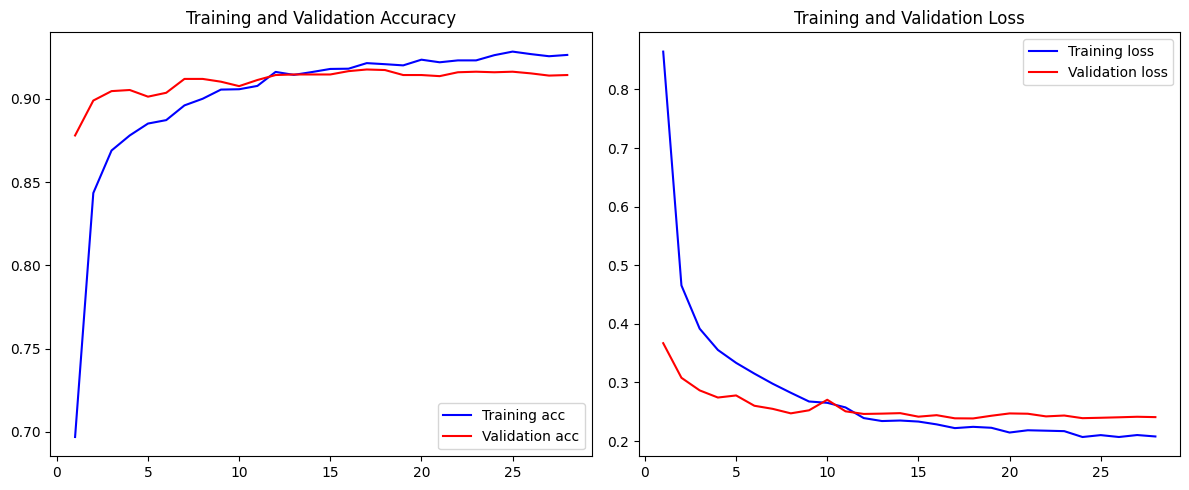

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Setelah melatih model, saya melanjutkan dengan memvisualisasikan hasil pelatihan untuk memantau bagaimana kinerja model selama proses pelatihan dan validasi. Saya mengambil nilai akurasi pelatihan (`accuracy`) dan akurasi validasi (`val_accuracy`), serta nilai loss pelatihan (`loss`) dan loss validasi (`val_loss`) dari objek `history.history`. Dengan menggunakan *matplotlib*, saya kemudian membuat dua subplot: yang pertama menampilkan grafik perbandingan antara akurasi pelatihan dan validasi selama pelatihan, dan yang kedua menampilkan perbandingan antara loss pelatihan dan validasi. Grafik-grafik ini membantu saya untuk mengevaluasi apakah model mengalami overfitting atau underfitting. Jika kedua kurva akurasi (training dan validation) memiliki kemiripan dan loss menunjukkan penurunan stabil, maka model sudah berjalan dengan baik. Sebaliknya, jika ada perbedaan signifikan antara kedua kurva tersebut, itu bisa menjadi tanda overfitting atau masalah lain pada pelatihan.

In [19]:
class_names_ds = test_ds.class_names
print('Class names dari test_dataset:', class_names_ds)

# Pastikan urutan class_names cocok dengan model output
# Kalau tidak cocok, kamu bisa mapping ulang nanti (saya bisa bantu)

# Evaluasi model di test dataset
loss, accuracy = model.evaluate(test_ds)
print(f'\nTest Accuracy: {accuracy:.4f}')


Class names dari test_dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
95/95 [==============================] - 60s 606ms/step - loss: 0.2078 - accuracy: 0.9263

Test Accuracy: 0.9263


Setelah mengevaluasi model pada dataset test, saya mendapatkan hasil yang cukup baik dengan akurasi 92,43% dan loss 0.2205. Ini menunjukkan bahwa model sudah dapat mengklasifikasikan gambar dengan tingkat keakuratan yang tinggi pada data yang tidak terlihat sebelumnya.

In [20]:
model.export("saved_model")  # folder akan dibuat otomatis


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='rescaling_1_input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2705931252944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971933264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971933456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971934032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971934992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971935376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971935568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971935184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2705971935952: TensorSpec(shape=()

Selanjutnya, setelah mengekspor model dengan `model.export("saved_model")`, saya melakukan penyimpanan model yang telah dilatih dalam format yang bisa digunakan untuk deployment atau digunakan kembali di masa mendatang. Dengan langkah ini, model disimpan dalam folder `saved_model` yang secara otomatis dibuat, memungkinkan untuk pemuatan model di lain waktu tanpa harus melatihnya kembali.

Penyimpanan model ini memungkinkan untuk mengoptimalkan waktu dan sumber daya, serta mempermudah implementasi model di berbagai lingkungan produksi.

Langkah selanjutnya, jika kamu ingin memuat dan menggunakan model tersebut, kamu bisa melakukan hal berikut:

```python
loaded_model = tf.keras.models.load_model("saved_model")
```

Dengan ini, model yang telah disimpan bisa langsung digunakan untuk prediksi atau melanjutkan pelatihan jika diperlukan.


In [21]:
# Convert to TFLite
os.makedirs("tflite", exist_ok=True)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# Simpan ke file
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# 5. Simpan label.txt (dari class_names)
with open("tflite/label.txt", "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


Setelah mengekspor model ke dalam format TFLite, saya melakukan konversi model tersebut agar bisa dijalankan pada perangkat yang mendukung TensorFlow Lite (misalnya perangkat mobile atau IoT). Berikut langkah-langkah yang saya lakukan:

1. **Membuat folder untuk menyimpan model TFLite**: Saya memastikan bahwa folder `tflite` sudah ada dengan menggunakan `os.makedirs()`.
2. **Konversi model ke format TFLite**: Menggunakan `tf.lite.TFLiteConverter.from_saved_model()`, saya mengonversi model yang sudah disimpan ke dalam format TFLite.
3. **Menyimpan model TFLite ke file**: Saya menyimpan model yang telah dikonversi dalam file `model.tflite` di folder `tflite/`.
4. **Menyimpan class labels**: Untuk keperluan prediksi di masa depan, saya juga menyimpan file `label.txt` yang berisi nama kelas yang sesuai dengan model.

Dengan ini, model siap digunakan pada perangkat mobile atau perangkat lain yang mendukung TensorFlow Lite.


In [ ]:
%tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

Selanjutnya, saya menyimpan model saya dalam bentuk TensorFlow\.js agar lebih mudah digunakan saat pengembangan aplikasi web atau Android. Dengan menggunakan perintah `tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model`, saya mengonversi model TensorFlow yang disimpan dalam format **SavedModel** ke dalam format **TensorFlow\.js**. Proses ini memungkinkan model untuk digunakan di aplikasi berbasis web dengan TensorFlow\.js. Setelah konversi, model dapat langsung digunakan di aplikasi web atau Android dengan memuatnya menggunakan TensorFlow\.js, sehingga memudahkan integrasi dan penggunaan model tanpa harus mengubah struktur aplikasi yang ada. TensorFlow\.js memberi kemudahan untuk menjalankan model pembelajaran mesin langsung di browser atau perangkat Android.

95/95 [==============================] - 59s 600ms/step


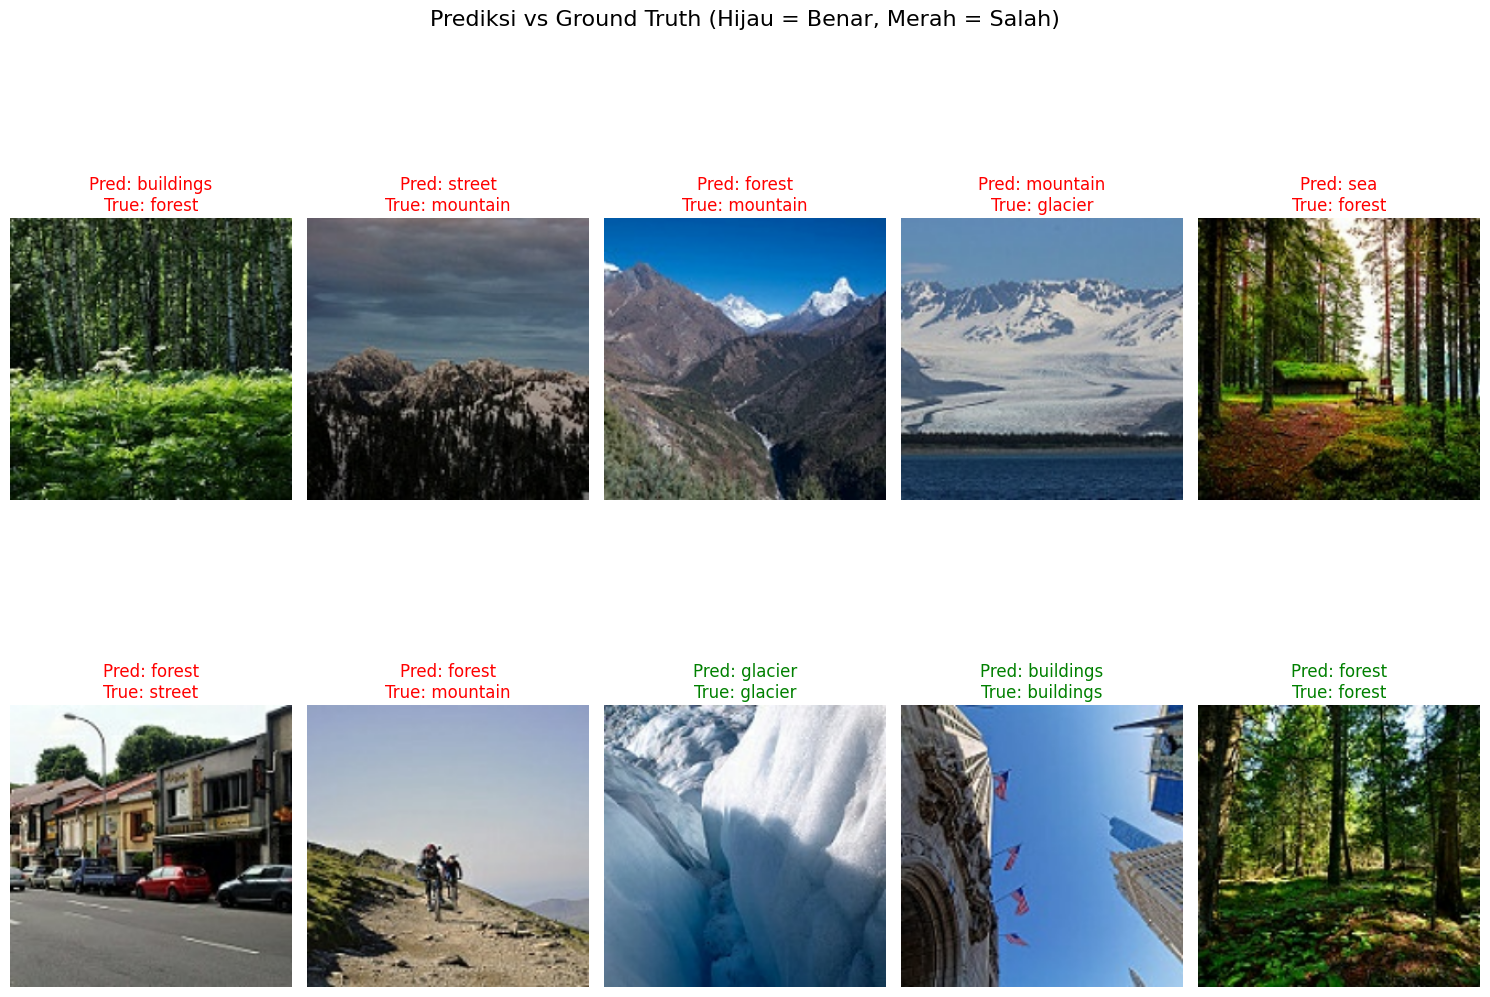

In [22]:
# Lakukan prediksi
y_pred_proba = model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred_labels = [class_names_ds[i] for i in y_pred]

# Ambil gambar dan label sebenarnya
images = []
y_true = []
for batch in test_ds:
    imgs, labels = batch
    images.append(imgs)
    y_true.append(labels)

images = np.concatenate(images)
y_true = np.concatenate(y_true)
y_true_indices = np.argmax(y_true, axis=1)
y_true_labels = [class_names_ds[i] for i in y_true_indices]

# Plot 10 gambar pertama dengan prediksi dan label asli
plt.figure(figsize=(15, 12))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].astype("uint8"))   # ← Hapus .numpy()
    plt.axis('off')
    title_color = 'green' if y_pred_labels[i] == y_true_labels[i] else 'red'
    plt.title(f'Pred: {y_pred_labels[i]}\nTrue: {y_true_labels[i]}', color=title_color)

plt.suptitle('Prediksi vs Ground Truth (Hijau = Benar, Merah = Salah)', fontsize=16)
plt.tight_layout()
plt.show()



Terakhir, saya mencoba inference testing dengan model yang saya simpan dalam format TensorFlow Lite (TFLite). Untuk pengujian ini, saya menggunakan data test yang ada di **data/seg_test**. Langkah pertama yang saya lakukan adalah memprediksi hasil menggunakan model yang sudah disimpan dengan format TFLite. Saya mendapatkan probabilitas prediksi untuk setiap kelas, kemudian memilih kelas dengan probabilitas tertinggi menggunakan `np.argmax()`. Setelah itu, saya mengonversi hasil prediksi menjadi label yang sesuai dengan kelas yang ada.

Selanjutnya, saya juga menampilkan gambar-gambar dari dataset test bersama dengan prediksi dan label aslinya. Gambar yang benar diprediksi ditandai dengan warna hijau pada judul, sementara gambar yang salah diprediksi ditandai dengan warna merah. Dengan cara ini, saya bisa memvisualisasikan bagaimana model melakukan inferensi pada data yang belum pernah dilihat sebelumnya dan mengevaluasi akurasi prediksinya.

Dengan menggunakan TFLite, saya dapat menguji model di perangkat mobile atau web dengan lebih efisien, karena TFLite dirancang untuk memberikan performa yang lebih baik dan lebih ringan di perangkat dengan sumber daya terbatas.